In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 23 17:50:04 2013

@author: salmon
"""

###############################################################################
#               Impoort part
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from matplotlib import rc
%matplotlib inline

###############################################################################
# Displaying labeled data
###############################################################################

symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': True,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#    Data Generation    (you can skip the understanding)
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [-1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.random.permutation((nbp + nbn) * 8)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])


###############################################################################
#            Displaying labeled data
###############################################################################
symlist = ['o', 's', '+', 'x', 'D', '*', 'p', 'v', '-', '^']
collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
           'fuchsia']


def plot_2d(X, y, w=None, step=50, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1], c=color_blind_list[label_num],
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0 - delta0 / 10., max_tot0 + delta0 / 10.])
    plt.ylim([min_tot1 - delta1 / 10., max_tot1 + delta1 / 10.])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)


###############################################################################
#               Loss functions and their gradient
###############################################################################

def predict(x, w):
    """ prediction from a normal vector"""
    return np.dot(x, w[1:]) + w[0]


def predict_class(x, w):
    """ predict a class from at point x thanks to a normal vector"""
    return np.sign(predict(x, w))


def zero_one_loss(x, y, w):
    """ 0-1 loss function"""
    return abs(y - np.sign(predict(x, w))) / 2.


def hinge_loss(x, y, w):
    """ hinge loss function"""
    return np.maximum(0., 1. - y * predict(x, w))


def mse_loss(x, y, w):
    """ fonction de cout moindres carres"""
    return (y - predict(x, w)) ** 2


def norm2(x, y, w):
    """squared norm of a vector"""
    return np.dot(w, w)


def gr_hinge_loss(x, y, w):
    """ (sub-)gradient of the loss function hingeloss"""
    return np.dot(-y * (hinge_loss(x, y, w) > 0.),
                  np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_mse_loss(x, y, w):
    """ gradient of the loss least squares lost function"""
    return -2. * np.dot(y - predict(x, w),
                        np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_norm2(x, y, w):
    """ gradient of the squared norm"""
    return 2. * w


def pen_loss_aux(x, y, w, l):
    """ loss function penalized by hinge loss """
    return hinge_loss(x, y, w) + l * norm2(x, y, w)


def gr_pen_loss_aux(x, y, w, l):
    """ gradient of hinge loss penalized loss function"""
    return gr_hinge_loss(x, y, w) + l * gr_norm2(x, y, w, )


def pen_loss(l):
    """penalized loss function"""
    return lambda x, y, w: pen_loss_aux(x, y, w, l)


def gr_penLoss(l):
    """gradient penalized loss function"""
    return lambda x, y, w: gr_pen_loss_aux(x, y, w, l)


###############################################################################
#            Displaying tools for the Frontiere
###############################################################################

def frontiere(f, X, step=50, cmap_choice=cm.coolwarm):
    """ trace la frontiere pour la fonction de decision f"""
    min_tot0 = np.min(X[:, 0])
    max_tot0 = np.max(X[:, 0])
    min_tot1 = np.min(X[:, 1])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest", cmap=cmap_choice,
               extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    plt.colorbar()


def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1], c=color_blind_list[label_num],
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)


def frontiere_3d(f, data, step=20):
    """plot the 3d frontiere for the decision function ff"""
    ax = plt.gca(projection='3d')
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    ax.plot_surface(xx, yy, z, rstride=1, cstride=1,
                    linewidth=0., antialiased=False,
                    cmap=plt.cm.coolwarm)


def plot_cout(X, y, lfun, w=None):
    """ Plot the cost function encoded by lfun,
    for data X, and label y, as a function of the weight parameter.
    W can be used to give a historic path of the weights """
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return lfun(X, y, ww).mean()
    datarange = np.array([[np.min(X[:, 0]), np.min(X[:, 1])],
                          [np.max(X[:, 0]), np.max(X[:, 1])]])
    frontiere(_inter, np.array(datarange))
    if w is not None:
        plt.plot(w[:, 1], w[:, 2], 'k')
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])


def plot_cout3d(x, y, lfun, w):
    """ trace le cout de la fonction cout lfun passee en parametre, en x,y,
        en faisant varier les coordonnees du poids w.
        W peut etre utilise pour passer un historique de poids"""
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return lfun(x, y, ww).mean()

    datarange = np.array([[w[:, 1].min(), w[:, 2].min()],
                         [w[:, 1].max(), w[:, 2].max()]])
    frontiere_3d(_inter, np.array(datarange))
    plt.plot(w[:, 1], w[:, 2], np.array([_inter(w[i, 1:]) for i in
             range(w.shape[0])]), 'k-', linewidth=3)

###############################################################################
#                Algorithms and functions
###############################################################################


def gradient(x, y, eps, niter, w_ini, lfun, gr_lfun, stochastic=True):
    """ algorithme de descente du gradient:
        - x : donnees
        - y : label
        - eps : facteur multiplicatif de descente
        - niter : nombre d'iterations
        - w_ini
        - lfun : fonction de cout
        - gr_lfun : gradient de la fonction de cout
        - stoch : True : gradient stochastique
        """
    w = np.zeros((niter, w_ini.size))
    w[0] = w_ini
    loss = np.zeros(niter)
    loss[0] = lfun(x, y, w[0]).mean()
    for i in range(1, niter):
        if stochastic:  # this is for Stochastic Gradient Descent
            idx = [np.random.randint(x.shape[0])]
        else:           # this is for pure Gradient Descent
            idx = np.arange(x.shape[0])
        w[i, :] = w[i - 1, :] - eps * gr_lfun(x[idx, :], y[idx], w[i - 1, :])
        loss[i] = lfun(x, y, w[i, :]).mean()
    return w, loss


def plot_gradient(X, y, wh, cost_hist, lfun):
    """ display 4 figures on how  (stochastic) gradient descent behaves
    wh : solution history
    cost_hist : cost history
    lfun : loss function
    """
    best = np.argmin(cost_hist)
    plt.subplot(221)
    plt.title('Data and hyperplane estimated')
    plot_2d(X, y, wh[best, :])
    plt.subplot(222)
    plt.title('Projection of level line and algorithm path')
    plot_cout(X, y, lfun, wh)
    plt.subplot(223)
    plt.title('Objective function vs iterations')
    plt.plot(range(cost_hist.shape[0]), cost_hist)
    plt.subplot(224, projection='3d')
    plt.title('Level line and algorithm path')
    plot_cout3d(X, y, lfun, wh)


###############################################################################
#                Polynomial transformations
###############################################################################


def poly2(x):
    """ creates features for second order interactions """
    if x.ndim == 1:
        x = x[None, :]
    nb, d = x.shape
    res = x
    for i in range(0, d):
        for j in range(i, d):
            res = np.hstack((res, x[:, i:i + 1] * x[:, j:j + 1]))
    return res


def poly3(x):
    """ creates features for third order interactions """
    if x.ndim == 1:
            x = x[None, :]
    nb, d = x.shape
    res = poly2(x)
    for i in range(0, d):
        for j in range(i, d):
            for k in range(j, d):
                res = np.hstack(
                    (res, x[:, i:i + 1] * x[:, j:j + 1] * x[:, k:k + 1]))
    return res


# Génération de données et visualisation

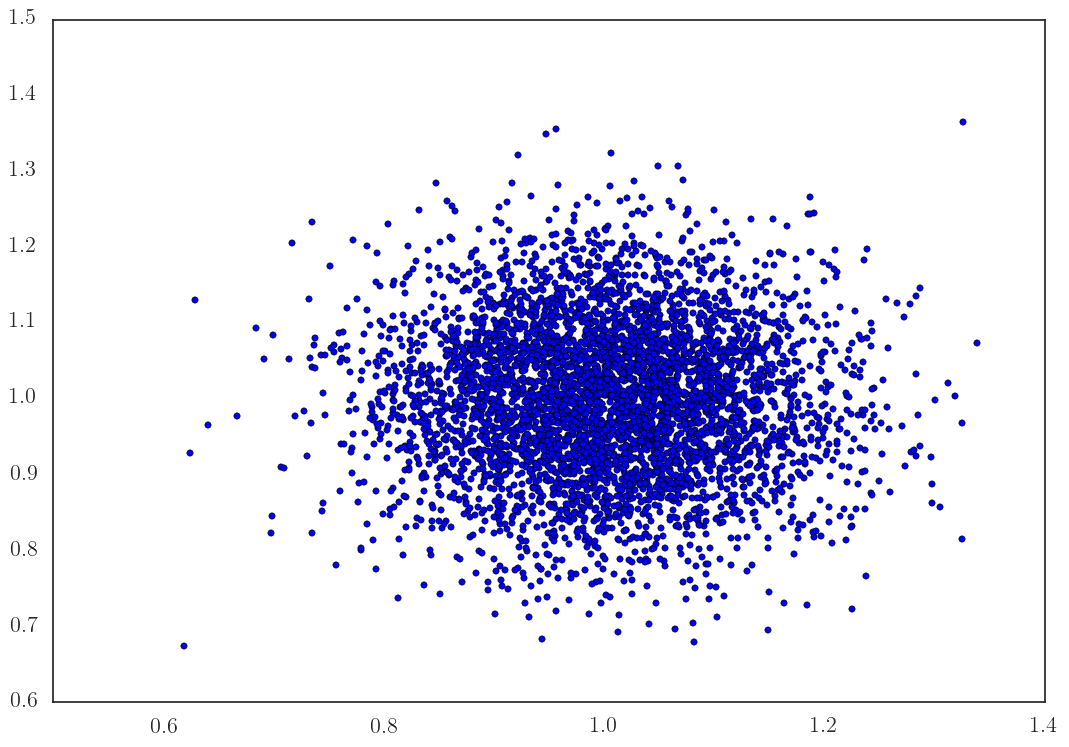

In [7]:
"""rand_gauss :"""
data_gauss = rand_gauss(n=5000)
plt.scatter(data_gauss[...,0], data_gauss[...,1])

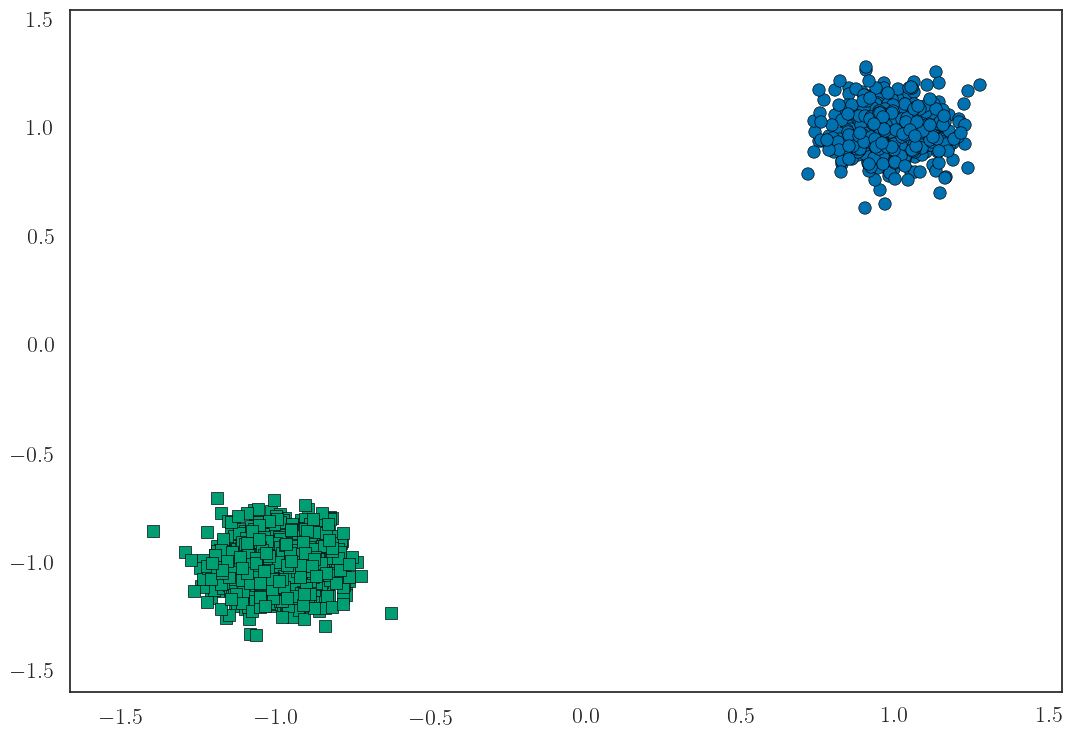

In [8]:
"""rand_bi_gauss :"""
data_bi_gauss = rand_bi_gauss(n1=1000, n2=500, mu1=[-1,-1], mu2=[+1,+1])
#print l
plot_2d(data_bi_gauss[0], data_bi_gauss[1])

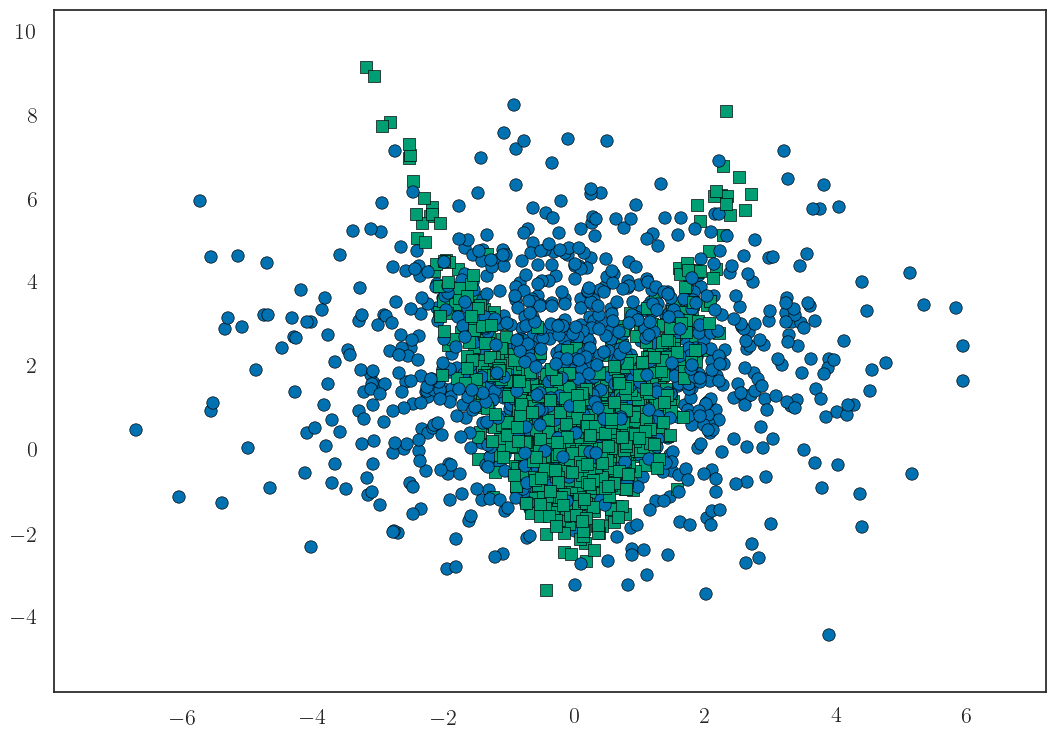

In [9]:
"""rand_clown :"""
data_clown = rand_clown(n1=1000, n2=1000)
#print l
plot_2d(data_clown[0], data_clown[1])

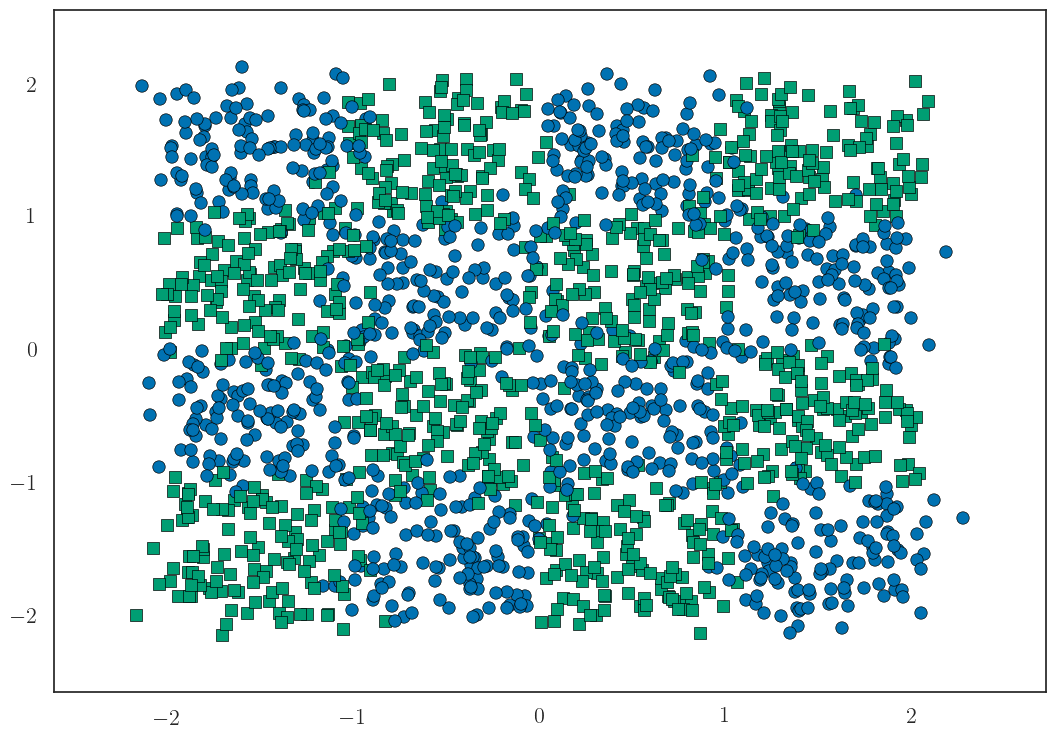

In [10]:
"""rand_checkers :"""
data_checkers = rand_checkers(n1=1000, n2=1000)
#print l
plot_2d(data_checkers[0], data_checkers[1])

# Les classifieurs linéaires (affines)

## 1) A quoi correspond la frontière de décision du perceptron en dimension p = 2 ?

En dimension 2, la frontière est une fonction affine (droite)

Pour mon jeu de données tiré de deux distributions gaussiennes, `data_bi_gauss`, un échantillon est centré autour de $\mu_1 = (-1.5, -1.1)$, et l'autre autour de  $\mu_2 = (-1,-1)$ (valeur par défaut).

Ainsi l'hyperplan est est la médiatrice entre ces deux points, et son vecteur directeur est le vecteur $\vec{\mu_1\mu_2}$.

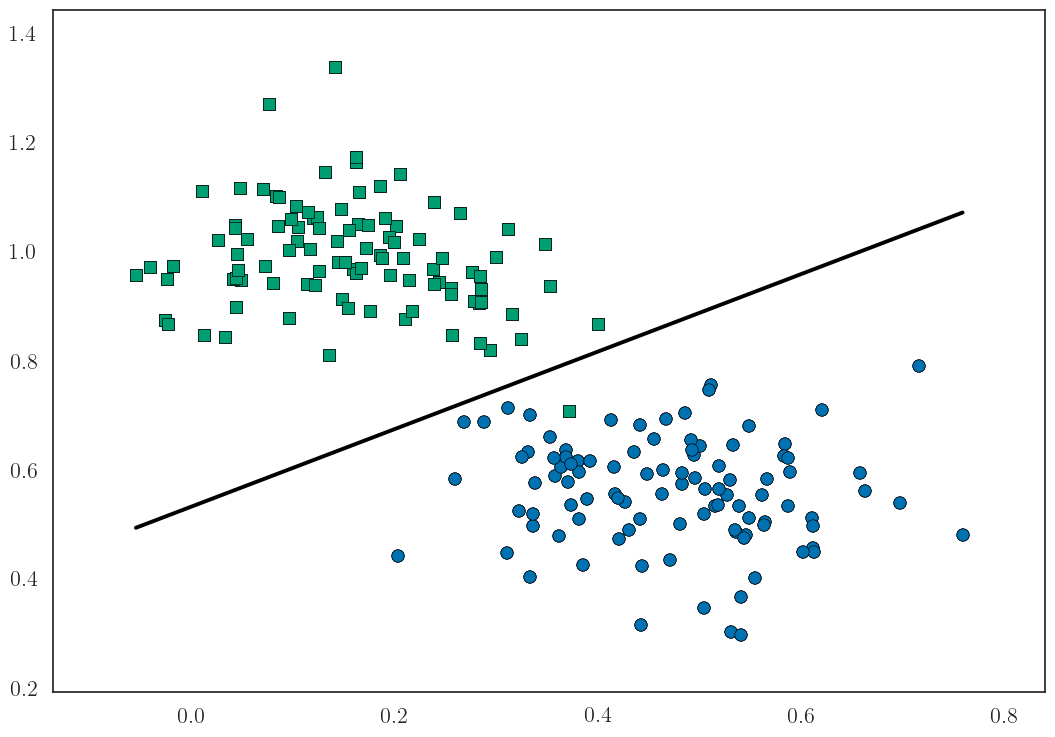

In [11]:
xa, ya = np.random.random_sample(), np.random.random_sample()
#xa, ya = 4,3
mu1=[xa,ya]
#print "mu1 =",mu1

xb, yb = np.random.random_sample(), np.random.random_sample()
mu2=[xb,yb]
#print "mu2 =",mu2

dx = xa-xb
dy = ya-yb

#print "dx =", dx
#print "dy =", dy

data_bi_gauss = rand_bi_gauss(n1=100, n2=100, mu1=mu1, mu2=mu2)
plot_2d(data_bi_gauss[0], data_bi_gauss[1])

intercept = (ya+yb)/2.+dx/dy*(xa+xb)/2.
#print "intercept =",intercept
w = [intercept, -dx/dy, -1]
#print "w =",w
plot_2d(data_bi_gauss[0], data_bi_gauss[1], w=w)


## 1) (Suite) Quand est-ce que $f_w (x)$ est grand ? négatif ? positif ? Quelle est la signification géométrique de cette fonction ? À quoi correspond $w_0$ ?

$f_w (x) = w_0 + \sum{w_i * x_i}$, ce nombre indique de quel côté de l'hyperplan le vecteur $x$ se trouve. 

Si ce nombre est positif, $x$ est dans la même direction que $w$ par rapport à l'hyperplan séparateur. 

Si ce nombre est grand, $x$ est éloigné de l'hyperplan séparateur.

$w_0$ est l'ordonnée à l'origine ("intercept" en anglais), et sert à translater l'hyperplan.

## 2) Vérifiez que la fonction `predict(x,w)` prend en entrée un vecteur $x \in R^p$ et un vecteur poids $w \in R^{p+1}$ et renvoie le vecteur de prédiction $f_w(x)$.

Au vu de l'implémentation, cela semble assez clair que la fonction `predict` fait ce qui est annoncé :

    def predict(x, w):
    """ prediction from a normal vector"""
    return np.dot(x, w[1:]) + w[0]
    
Pour vérifier :

In [12]:
print "<w,mu1> =", predict(mu1,w)
print "<w,mu2> =", predict(mu2,w)
print "<w,(mu1+mu2)/2> = ", predict(np.divide(np.add(mu1, mu2), 2), w)


<w,mu1> = -0.321460920549
<w,mu2> = 0.321460920549
<w,(mu1+mu2)/2> =  0.0


## 2) (Suite) Vérifiez ensuite que `predict_class(x,w)` renvoie bien l’étiquette prédite $sign (f_w (x))$.

De même, on voit que l'implémentation est assez claire :

    def predict_class(x, w):
    """ predict a class from at point x thanks to a normal vector"""
    return np.sign(predict(x, w))

On peut vérifier expérimentalement que tous les points sont bien assignés :

In [13]:
bad = 0
for i, (point, label) in enumerate(zip(data_bi_gauss[0], data_bi_gauss[1])):
    if(label != predict_class(point, w)):
        bad = bad + 1
#         print "Wrong prediction for point number",i,":",point, bad
#         print "Should be", label
print "All done, bad labels = ",min(bad, i+1-bad),"/",i+1
# I use min(bad, i+1-bad) because 100% of bad labelling = Good score.

All done, bad labels =  1 / 200


## 3) Fonctions de coût :

### Perte 0/1 :
$ZOL(f_w (x), y) = |y − sign(f_w (x))|/2$

Soit $F_{ZOL}:w \mapsto l(f_w(x), y)$

**Cette fonction est constante par morceaux :**

$F_{ZOL}(w) = \frac{|y-1|}{2}$ si $f_w (x) \ge 0$, ou $F_{ZOL}(w) = \frac{|y+1|}{2}$ sinon

Plus précisément : $f_w (x) \ge 0 \Leftrightarrow w_0 + \sum{w_i * x_i} \ge 0$


### Erreur quadratique :

Soit $F_{MSE}:w \mapsto (y − f_w (x))^2$

Montrons que $F_{MSE}$ est une forme quadratique.

Soit $B: (u,v) \mapsto (y − f_u (x))(y − f_v (x))$.

Alors :

- $B(u,v) = B(v,u)$
- $B(u+v, w) = (y − f_{u+v} (x))(y − f_w (x))$, 

    or $f_{u+v} (x) = u_0 + v_0 + \sum_{j=1}^p{(u_j + v_j)*x_j} = f_u(x) + f_v(x)$.
    
    Ainsi $B(u+v, w) = B(u,w) + B(v,w)$.
    
- $B(\lambda u, v)


### Erreur *hinge* :

